In [30]:
import YouTube_Data_Story as ds
import YouTube_Data_Wrangling as dw
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import holidays
import datetime
from datetime import date
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, VotingClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve

In [2]:
df_combined_usa_mx=dw.combined_usa_mx_df

In [3]:
df_views=df_combined_usa_mx.views
df_likes=df_combined_usa_mx.likes
df_dlikes=df_combined_usa_mx.dislikes
df_cc=df_combined_usa_mx.comment_count

#df for logs of views/likes/dlikes/cc.

df_dlikes_log=np.log(df_dlikes.where(df_dlikes > 0, np.median(df_dlikes)))
df_likes_log=np.log(df_likes.where(df_likes > 0, np.median(df_likes)))
df_cc_log=np.log(df_cc.where(df_cc > 0, np.median(df_cc)))
df_views_log=np.log(df_views.where(df_views > 0, np.median(df_views)))

#df_corr - to find corr between likes/dlikes/cc/views
df_corr=df_combined_usa_mx[['views','likes','dislikes','comment_count']]
df_corr.columns=['views','likes','dlikes','cc']

#df_log - to create 3D plot

df_log=pd.DataFrame()
df_log.insert(0, column='views_log', value=df_views_log)
df_log.insert(1, column='likes_log', value=df_likes_log)
df_log.insert(2, column='dlikes_log', value=df_dlikes_log)
df_log.insert(3, column='cc_log', value=df_cc_log)


In [4]:
#Functions

def histograming(ax,df,title, xlabel):
    ax.hist(df, bins=20)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency")
    
def graph3D(ax, x, y, z, classifier, x_label, y_label, z_label, title):
    sp = ax.scatter(x,y,z, s=30, c=classifier)
    #plt.colorbar(sp)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))
    ax.zaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))   

def graph3Dlog(ax, x, y, z, classifier, x_label, y_label, z_label, title):
    sp = ax.scatter(x,y,z, s=30, c=classifier)
    #plt.colorbar(sp)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)

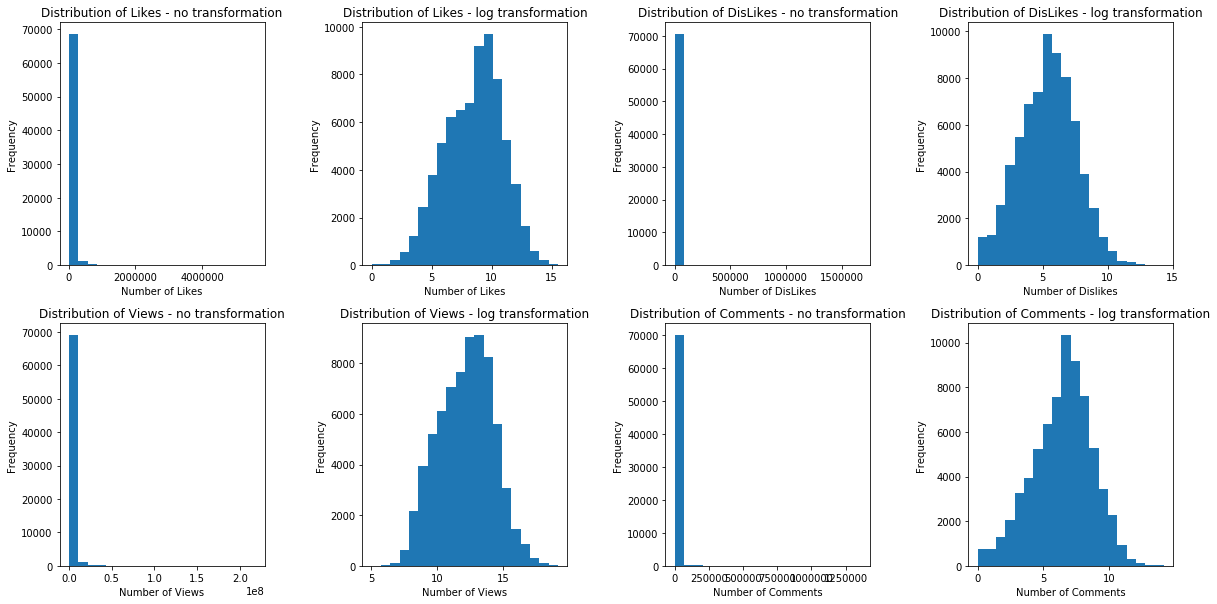

In [5]:
#Log Transforming likes/dislikes/views/cc so that the distributions are not skewed.

fig, ax =plt.subplots(2,4)
fig.set_size_inches(17, 8.5, forward=True)

histograming(ax[0,0],df_likes,"Distribution of Likes - no transformation", "Number of Likes") 
histograming(ax[0,1],df_likes_log,"Distribution of Likes - log transformation", "Number of Likes" )
histograming(ax[0,2],df_dlikes,"Distribution of DisLikes - no transformation", "Number of DisLikes" )
histograming(ax[0,3],df_dlikes_log,"Distribution of DisLikes - log transformation", "Number of Dislikes" )

histograming(ax[1,0],df_views,"Distribution of Views - no transformation", "Number of Views")
histograming(ax[1,1],df_views_log,"Distribution of Views - log transformation", "Number of Views" )
histograming(ax[1,2],df_cc,"Distribution of Comments - no transformation", "Number of Comments" )
histograming(ax[1,3],df_cc_log,"Distribution of Comments - log transformation", "Number of Comments" )
plt.tight_layout()

#### After log transformation views, likes, dislikes and cc are normally distributed. 

In [6]:
#Correlation between views, likes, dislikes and cc. 

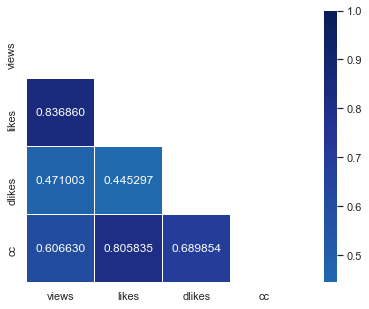

In [7]:
import seaborn as sns
sns.set(style="white")
# Compute the correlation matrix
corr = df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9,5))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap='YlGnBu',   center=0,
            square=True, linewidths=.5, annot=True, fmt="f")

#### None of the correlations are "strong enough". likes/views and likes/cc are more than 80% correlated. However I dont see that a person who views a video will definitly give "like" to it or "comment on it". The correlation exists but not causation. 
Based on this I will try following

1. I would check if elbow method shows any optimal number of clusters. fit_predict Kmeans clusters based on optimal k

2. TBD 

In [8]:
#KMeans elbow method to check for optimal K
inertia = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_corr)
    inertia.append(kmeans.inertia_)

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

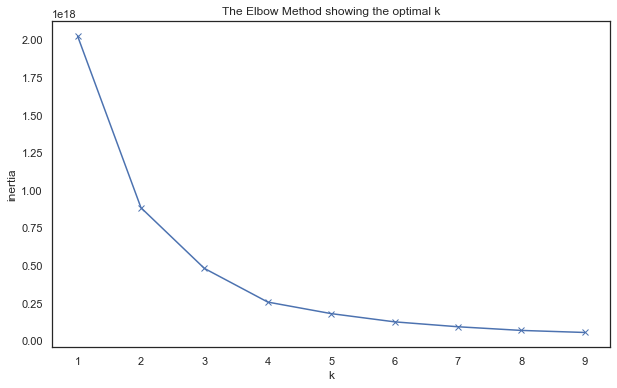

In [9]:
plt.figure(figsize=(10,6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')

In [10]:
#from above elbow plot I can see that optimal K could be 3 or 4. Taking kmeans for both. 
kmeans3 = KMeans(n_clusters=3, random_state=0).fit(df_corr)
pop_class3=kmeans3.predict(df_corr)

kmeans4 = KMeans(n_clusters=4, random_state=0).fit(df_corr)
pop_class4=kmeans4.predict(df_corr)

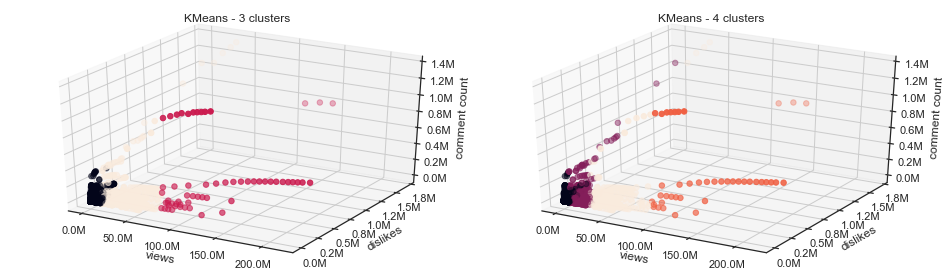

In [11]:
fig = plt.figure(figsize=plt.figaspect(0.3)) ## set up a figure twice as wide as it is tall
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

graph3D(ax1, df_corr['views'], df_corr['dlikes'], df_corr['cc'], pop_class3, "views", "dislikes", "comment count", "KMeans - 3 clusters")
graph3D(ax2, df_corr['views'], df_corr['dlikes'], df_corr['cc'], pop_class4, "views", "dislikes", "comment count", "KMeans - 4 clusters")

plt.tight_layout()

In [12]:
#We can clearly see at that at K=3 or 4 the inertia no longer decrease at a rate that it decreased from K=1 and K=2. 
#Optimal K could be 3 or 4. 

#I can now plot the same graph but for transformed data of likes/dislikes/cc/views. 
# It will give better pic of how many clusters I should use

In [13]:
kmeans3_log = KMeans(n_clusters=3, random_state=0).fit_predict(df_log)
kmeans4_log = KMeans(n_clusters=4, random_state=0).fit_predict(df_log)

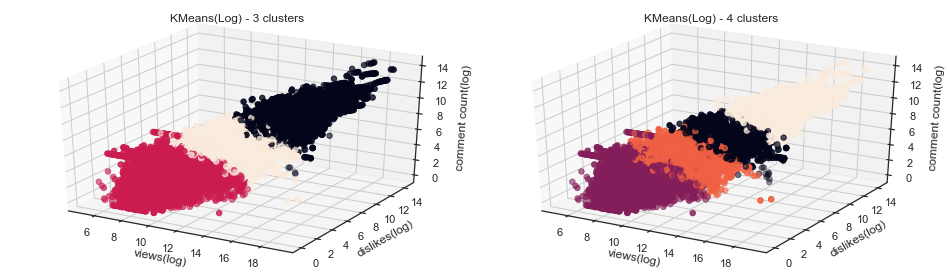

In [14]:
fig = plt.figure(figsize=plt.figaspect(0.3)) ## set up a figure twice as wide as it is tall
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

graph3Dlog(ax1, df_log['views_log'], df_log['dlikes_log'], df_log['cc_log'], kmeans3_log, "views(log)", "dislikes(log)", "comment count(log)", "KMeans(Log) - 3 clusters")
graph3Dlog(ax2, df_log['views_log'], df_log['dlikes_log'], df_log['cc_log'], kmeans4_log, "views(log)", "dislikes(log)", "comment count(log)", "KMeans(Log) - 4 clusters")

plt.tight_layout()

In [15]:
#optimal K after looking at clusters using transformed data = 4

In [16]:
#Adding pop_class (popularity class in the df_combined_usa_mx using clusters in pop_class4

In [17]:
df_combined_usa_mx.insert(13, column='pop_class', value=pop_class4)

In [18]:
df_combined_usa_mx.drop(['comments_disabled','ratings_disabled','video_error_or_removed'], axis=1, inplace=True)

In [19]:
df_classification=df_combined_usa_mx.drop(['views','likes','dislikes','comment_count'], axis=1)

In [20]:
df_classification['publish_year']=df_classification['publish_time'].dt.year
df_classification['publish_day']=df_classification['publish_time'].dt.day
df_classification['publish_mon']=df_classification['publish_time'].dt.month

In [21]:
df_classification['trending_year']=df_classification['trending_date'].dt.year
df_classification['trending_day']=df_classification['trending_date'].dt.day
df_classification['trending_mon']=df_classification['trending_date'].dt.month

########################## Inserting Holidays in dataframe.holiday=1 if holiday was observed in usa/mx in 2017/2018 #########

In [22]:
us_holiday=[]
mx_holiday=[]

for date in holidays.UnitedStates(years=[2018,2017]).items():
    us_holiday.append(str(date[0]).split()[0])
for date in holidays.Mexico(years=[2018,2017]).items():
    mx_holiday.append(str(date[0]).split()[0])

In [23]:
#changing publish_time to string object 
df_classification['pub_time_str'] = df_classification['publish_time'].dt.strftime("%Y-%m-%d")

#creating usa and mx df seperate, adding col holiday to both based in respective holidays
df_classification_usa=df_classification[df_classification.country=='USA']
df_classification_usa['holiday']=df_classification_usa.pub_time_str.apply(lambda x: 1 if x in us_holiday else 0) 

df_classification_mx=df_classification[df_classification.country=='Mexico']
df_classification_mx['holiday']=df_classification_mx.pub_time_str.apply(lambda x: 1 if x in mx_holiday else 0) 

#appending holidays col of usa and mx dfs and adding to original df (df_classification)
df_classification['holiday']=df_classification_usa['holiday'].append(df_classification_mx['holiday'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [24]:
#1912 rows were tagged as holidays in the dataframe based on the publish_time

## Classification of the popularity of the videos############################

In [25]:
df_classification_save=df_classification
df_classification.drop(['title','trending_date','pub_time_str','publish_time','category_name'], axis=1, inplace=True)

In [26]:
df_classification.head()

,category_id,country,pop_class,publish_year,publish_day,publish_mon,trending_year,trending_day,trending_mon,holiday
0,22,USA,0,2017,13,11,2017,14,11,0
1,24,USA,0,2017,13,11,2017,14,11,0
2,23,USA,0,2017,12,11,2017,14,11,0
3,24,USA,0,2017,13,11,2017,14,11,0
4,24,USA,0,2017,12,11,2017,14,11,0


In [32]:
### preprocessing
enc=preprocessing.LabelEncoder()
enc=enc.fit(df_classification['country'])
df_classification['country_transformed']=enc.transform(df_classification['country'])

In [34]:
df_classification['country']=df_classification['country_transformed']

In [36]:
df_classification.drop(['country_transformed'], axis=1)

,category_id,country,pop_class,publish_year,publish_day,publish_mon,trending_year,trending_day,trending_mon,holiday
0,22,1,0,2017,13,11,2017,14,11,0
1,24,1,0,2017,13,11,2017,14,11,0
2,23,1,0,2017,12,11,2017,14,11,0
3,24,1,0,2017,13,11,2017,14,11,0
4,24,1,0,2017,12,11,2017,14,11,0
...,...,...,...,...,...,...,...,...,...,...
81046,17,0,0,2018,13,6,2018,14,6,0
81047,25,0,0,2018,13,6,2018,14,6,0
81048,24,0,0,2018,13,6,2018,14,6,0
81049,22,0,0,2018,13,6,2018,14,6,0


In [40]:
X=df_classification.drop(['pop_class'], axis=1)

In [56]:
X_2=df_classification[['country','category_id']]

In [39]:
y=df_classification['pop_class']

In [42]:
X_train,X_test, y_train, y_test =train_test_split(X,y, random_state=0) #75% training set, 25%test set (defaults)

In [57]:
#With only 2 inputs/features
X_2_train,X_2_test, y_2_train, y_2_test =train_test_split(X_2,y, random_state=0) #75% training set, 25%test set (defaults)

In [45]:
X_train.shape, y_train.shape

((53096, 10), (53096,))

In [46]:
X_test.shape, y_test.shape

((17699, 10), (17699,))

In [59]:
X_2_train.shape,y_2_train.shape, X_2_test.shape, y_2_test.shape

((53096, 2), (53096,), (17699, 2), (17699,))

In [47]:
param_grid={'n_neighbors': np.arange(1,50)}

knn=KNeighborsClassifier()

knn_cv=GridSearchCV(knn,param_grid)

knn_cv.fit(X_train, y_train)
y_pred=knn_cv.predict(X_test)

In [48]:
knn_score_test=knn_cv.score(X_test, y_test)
#knn_score_hold=knn_cv.score(X_hold, y_pred_hold)
knn_score_test

0.9645177693655008

In [49]:
knn_cv.best_score_, knn_cv.best_params_, knn_cv.best_estimator_

(0.9629915712677185, {'n_neighbors': 8}, KNeighborsClassifier(n_neighbors=8))

In [64]:
param_grid={'n_neighbors': np.arange(1,50)}

knn2=KNeighborsClassifier()

knn2_cv=GridSearchCV(knn2,param_grid)

knn2_cv.fit(X_2_train, y_2_train)
y_2_pred=knn2_cv.predict(X_2_test)

In [68]:
knn2_score_test=knn2_cv.score(X_2_test, y_2_test)
knn2_score_test, knn2_cv.best_score_, knn2_cv.best_params_, knn2_cv.best_estimator_

(0.9646307701000056,
 0.9629162275131684,
 {'n_neighbors': 2},
 KNeighborsClassifier(n_neighbors=2))

In [67]:
df_combined_usa_mx.head()

,trending_date,title,category_id,publish_time,views,likes,dislikes,comment_count,category_name,country,pop_class
0,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,22,2017-11-13,748374,57527,2966,15954,People & Blogs,USA,0
1,2017-11-14,The Trump Presidency: Last Week Tonight with J...,24,2017-11-13,2418783,97185,6146,12703,Entertainment,USA,0
2,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",23,2017-11-12,3191434,146033,5339,8181,Comedy,USA,0
3,2017-11-14,Nickelback Lyrics: Real or Fake?,24,2017-11-13,343168,10172,666,2146,Entertainment,USA,0
4,2017-11-14,I Dare You: GOING BALD!?,24,2017-11-12,2095731,132235,1989,17518,Entertainment,USA,0
